In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We opted for the Eurostat database to investigate overarching modal split trends in European transportation, focusing on car, train, and bus usage across all European countries since 1990. This choice was driven by the database's comprehensive coverage and longitudinal data, providing a solid foundation for gaining an initial understanding in the general transportation trends.

For all data sourced from the Eurostat database, the data cleaning was similar: Upon importing and reading the data, we filtered out aggregated entries and removed Turkey from our analysis to maintain a focus on European trends. To streamline our analysis, we eliminated flags indicating provisional or estimated data and treated missing values as NaN, ensuring a cleaner dataset.

Our primary inquiry centered on identifying and understanding the prevailing trends in Europe's modal split over the past decade, with a particular interest in any significant shifts or patterns. Our findings revealed a pronounced increase in car usage, a decline in bus usage, and a gradual resurgence in train usage, following a dip in the late '90s. Notably, the pandemic era marked a decline in public transportation use, contrasted by a significant surge in car usage. This trend solidified the car's position as the most favored mode of transportation, followed by buses and trains. This question was crucial as it guided our subsequent, more granular examination of the data.

In [25]:
# Define the relative path to the CSV file
modal_split_file_path = '../data/eurostat/modal split percentage of inland passenger transport - tran_hv_psmod.csv'

# Read the CSV file
modal_split_data = pd.read_csv(modal_split_file_path)

# Convert to DataFrame
modal_split_df = pd.DataFrame(modal_split_data)

In [26]:
# Split 'unit,vehicle,geo\\time' into separate columns for 'unit', 'vehicle', and 'country'
modal_split_df[['unit', 'vehicle', 'country']] = modal_split_df['unit,vehicle,geo\\time'].str.split(',', expand=True)
modal_split_df.drop('unit,vehicle,geo\\time', axis=1, inplace=True)

# Replace various forms of NaN representations
nan_values = {": c": np.nan, ":": np.nan, " :": np.nan, ": ": np.nan, ": p": np.nan}
modal_split_df.replace(nan_values, inplace=True)

# Exclude specific geographical entities
excluded_rows = ['EU27_2020', 'EU28', 'TRN_BUS_TOT_AVD', 'TR']
modal_split_df = modal_split_df[~modal_split_df['country'].isin(excluded_rows)]

# Function to clean non-numeric suffixes and handle empty strings
def clean_data_suffixes(df):
    for col in df.columns:
        # Remove non-numeric suffixes and convert empty strings to NaN
        df[col] = df[col].replace(to_replace=r'[^\d.]+', value='', regex=True).replace('', np.nan).astype(float)
    return df

# Separate tables for BUS_TOT, CAR, and TRN, set 'country' as the index, and drop 'vehicle' and 'unit' columns
bus_df = modal_split_df[modal_split_df['vehicle'] == 'BUS_TOT'].drop(['unit', 'vehicle'], axis=1).set_index('country')
car_df = modal_split_df[modal_split_df['vehicle'] == 'CAR'].drop(['unit', 'vehicle'], axis=1).set_index('country')
trn_df = modal_split_df[modal_split_df['vehicle'] == 'TRN'].drop(['unit', 'vehicle'], axis=1).set_index('country')

# Sort the columns (years) in ascending order for each DataFrame
bus_df = bus_df.reindex(sorted(bus_df.columns), axis=1)
car_df = car_df.reindex(sorted(car_df.columns), axis=1)
trn_df = trn_df.reindex(sorted(trn_df.columns), axis=1)

# Clean the 'BUS', 'CAR', and 'TRN' DataFrames
bus_df_cleaned = clean_data_suffixes(bus_df.copy())
car_df_cleaned = clean_data_suffixes(car_df.copy())
trn_df_cleaned = clean_data_suffixes(trn_df.copy())

# Display the first few rows of each cleaned DataFrame
print("Bus Data:")
display(bus_df_cleaned.head())
print("\nCar Data:")
display(car_df_cleaned.head())
print("\nTrain Data:")
display(trn_df_cleaned.head())

Bus Data:


,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
country,,,,,,,,,,,,,,,,,,,,,
AT,11.0,10.6,10.5,10.7,10.6,10.9,10.7,10.9,10.9,10.7,...,10.0,9.9,9.9,9.9,9.9,10.0,9.5,9.7,9.3,9.0
BE,10.6,10.7,10.7,10.9,11.8,11.3,11.3,11.1,11.0,10.9,...,12.5,15.2,11.5,11.0,10.5,10.2,10.3,10.4,8.2,8.2
BG,NaN,NaN,NaN,NaN,NaN,29.3,25.3,24.0,24.5,21.9,...,14.8,14.0,15.1,14.6,14.1,13.1,12.0,13.0,8.6,8.0
CH,3.7,3.9,4.0,3.9,4.0,3.8,3.6,3.6,5.3,5.2,...,5.7,5.7,5.8,5.9,5.9,5.9,5.9,6.1,5.8,5.9
CY,NaN,NaN,NaN,NaN,NaN,22.7,22.9,22.6,22.3,22.1,...,18.7,18.5,18.2,18.7,18.6,19.0,18.9,18.5,12.6,12.7



Car Data:


,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
country,,,,,,,,,,,,,,,,,,,,,
AT,77.1,77.0,77.0,77.2,77.8,77.2,77.4,79.0,79.4,79.6,...,78.2,77.8,77.9,78.1,78.0,78.0,77.0,76.4,81.5,81.2
BE,83.3,83.3,83.3,83.3,82.6,82.9,82.9,83.0,83.1,83.1,...,80.6,77.8,81.0,81.5,81.9,82.0,81.7,81.4,85.0,85.6
BG,NaN,NaN,NaN,NaN,NaN,59.6,61.9,61.0,63.3,67.9,...,82.1,83.0,82.3,83.1,83.7,84.8,85.8,84.7,89.4,89.9
CH,82.1,81.1,81.4,80.9,79.8,82.3,82.5,82.5,81.1,81.0,...,75.0,75.0,74.6,74.4,74.3,74.5,74.8,73.9,79.9,79.5
CY,NaN,NaN,NaN,NaN,NaN,77.3,77.1,77.4,77.7,77.9,...,81.3,81.5,81.8,81.3,81.4,81.0,81.1,81.5,87.4,87.3



Train Data:


,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
country,,,,,,,,,,,,,,,,,,,,,
AT,11.9,12.4,12.5,12.1,11.6,12.0,11.9,10.1,9.8,9.6,...,11.8,12.3,12.2,12.1,12.1,12.0,13.5,13.9,9.2,9.8
BE,6.1,6.1,6.0,5.9,5.6,5.8,5.9,5.9,5.9,6.0,...,6.9,7.0,7.4,7.6,7.6,7.8,8.0,8.2,6.9,6.2
BG,NaN,NaN,NaN,NaN,NaN,11.2,12.8,15.0,12.2,10.2,...,3.1,2.9,2.6,2.3,2.2,2.1,2.2,2.2,2.0,2.1
CH,14.2,15.0,14.6,15.2,16.2,13.9,13.9,13.9,13.6,13.8,...,19.2,19.3,19.6,19.7,19.8,19.6,19.3,20.0,14.3,14.6
CY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For visualizations, we used line plots to depict the temporal trends of bus, car, and train usage. These plots vividly illustrated how the popularity of each transportation mode evolved over time. Furthermore, made stacked bar plots for individual countries, offering a clearer visual breakdown of commuting preferences within each nation. 

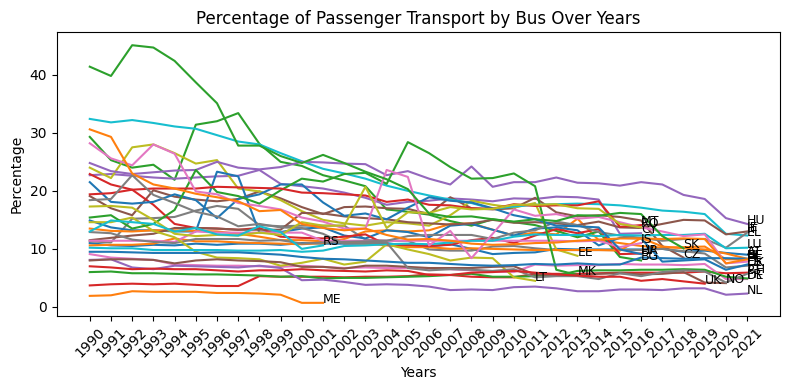

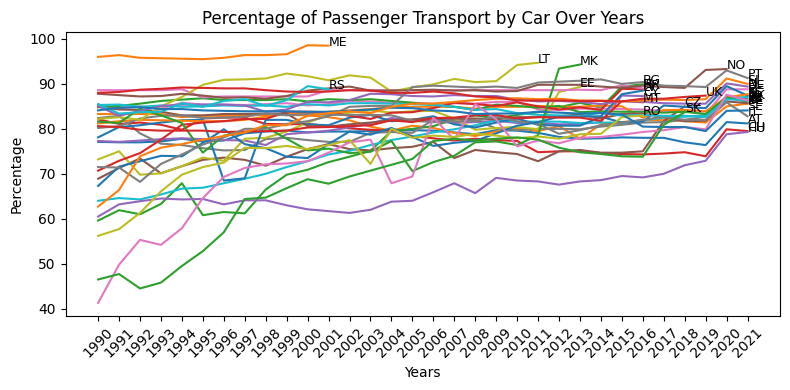

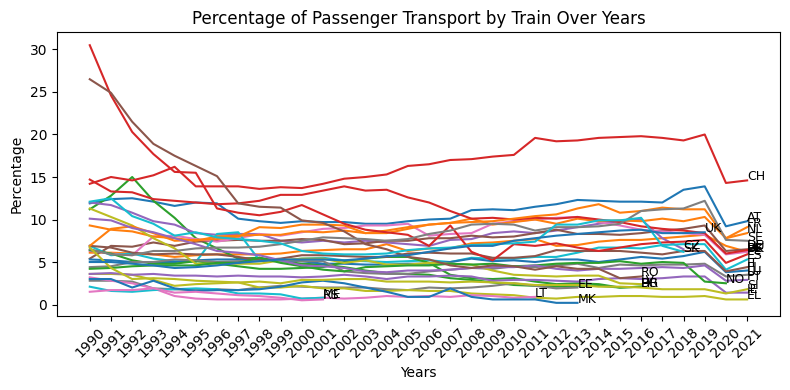

In [27]:
# Modified function to plot data with country code labels on each line, ensuring matching dimensions
def plot_data(df, title):
    plt.figure(figsize=(8, 4))

    # Convert the column names (years) to strings for the x-axis
    year_columns = df.columns.astype(str)

    # Loop through each country and plot its data with country codes on the lines
    for country in df.index:
        # Extract country data and align it with the year columns
        country_data = df.loc[country].reindex(year_columns).dropna()
        if not country_data.empty:
            plt.plot(year_columns[:len(country_data)], country_data)
            # Add text label near the last point of each line
            last_year = year_columns[len(country_data) - 1]
            last_value = country_data.iloc[-1]
            plt.text(last_year, last_value, country, fontsize=9)

    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylabel('Percentage')
    plt.xlabel('Years')
    plt.tight_layout()
    plt.show()

# Plotting Bus, Car, and Train Data with country labels
plot_data(bus_df_cleaned, 'Percentage of Passenger Transport by Bus Over Years')
plot_data(car_df_cleaned, 'Percentage of Passenger Transport by Car Over Years')
plot_data(trn_df_cleaned, 'Percentage of Passenger Transport by Train Over Years')


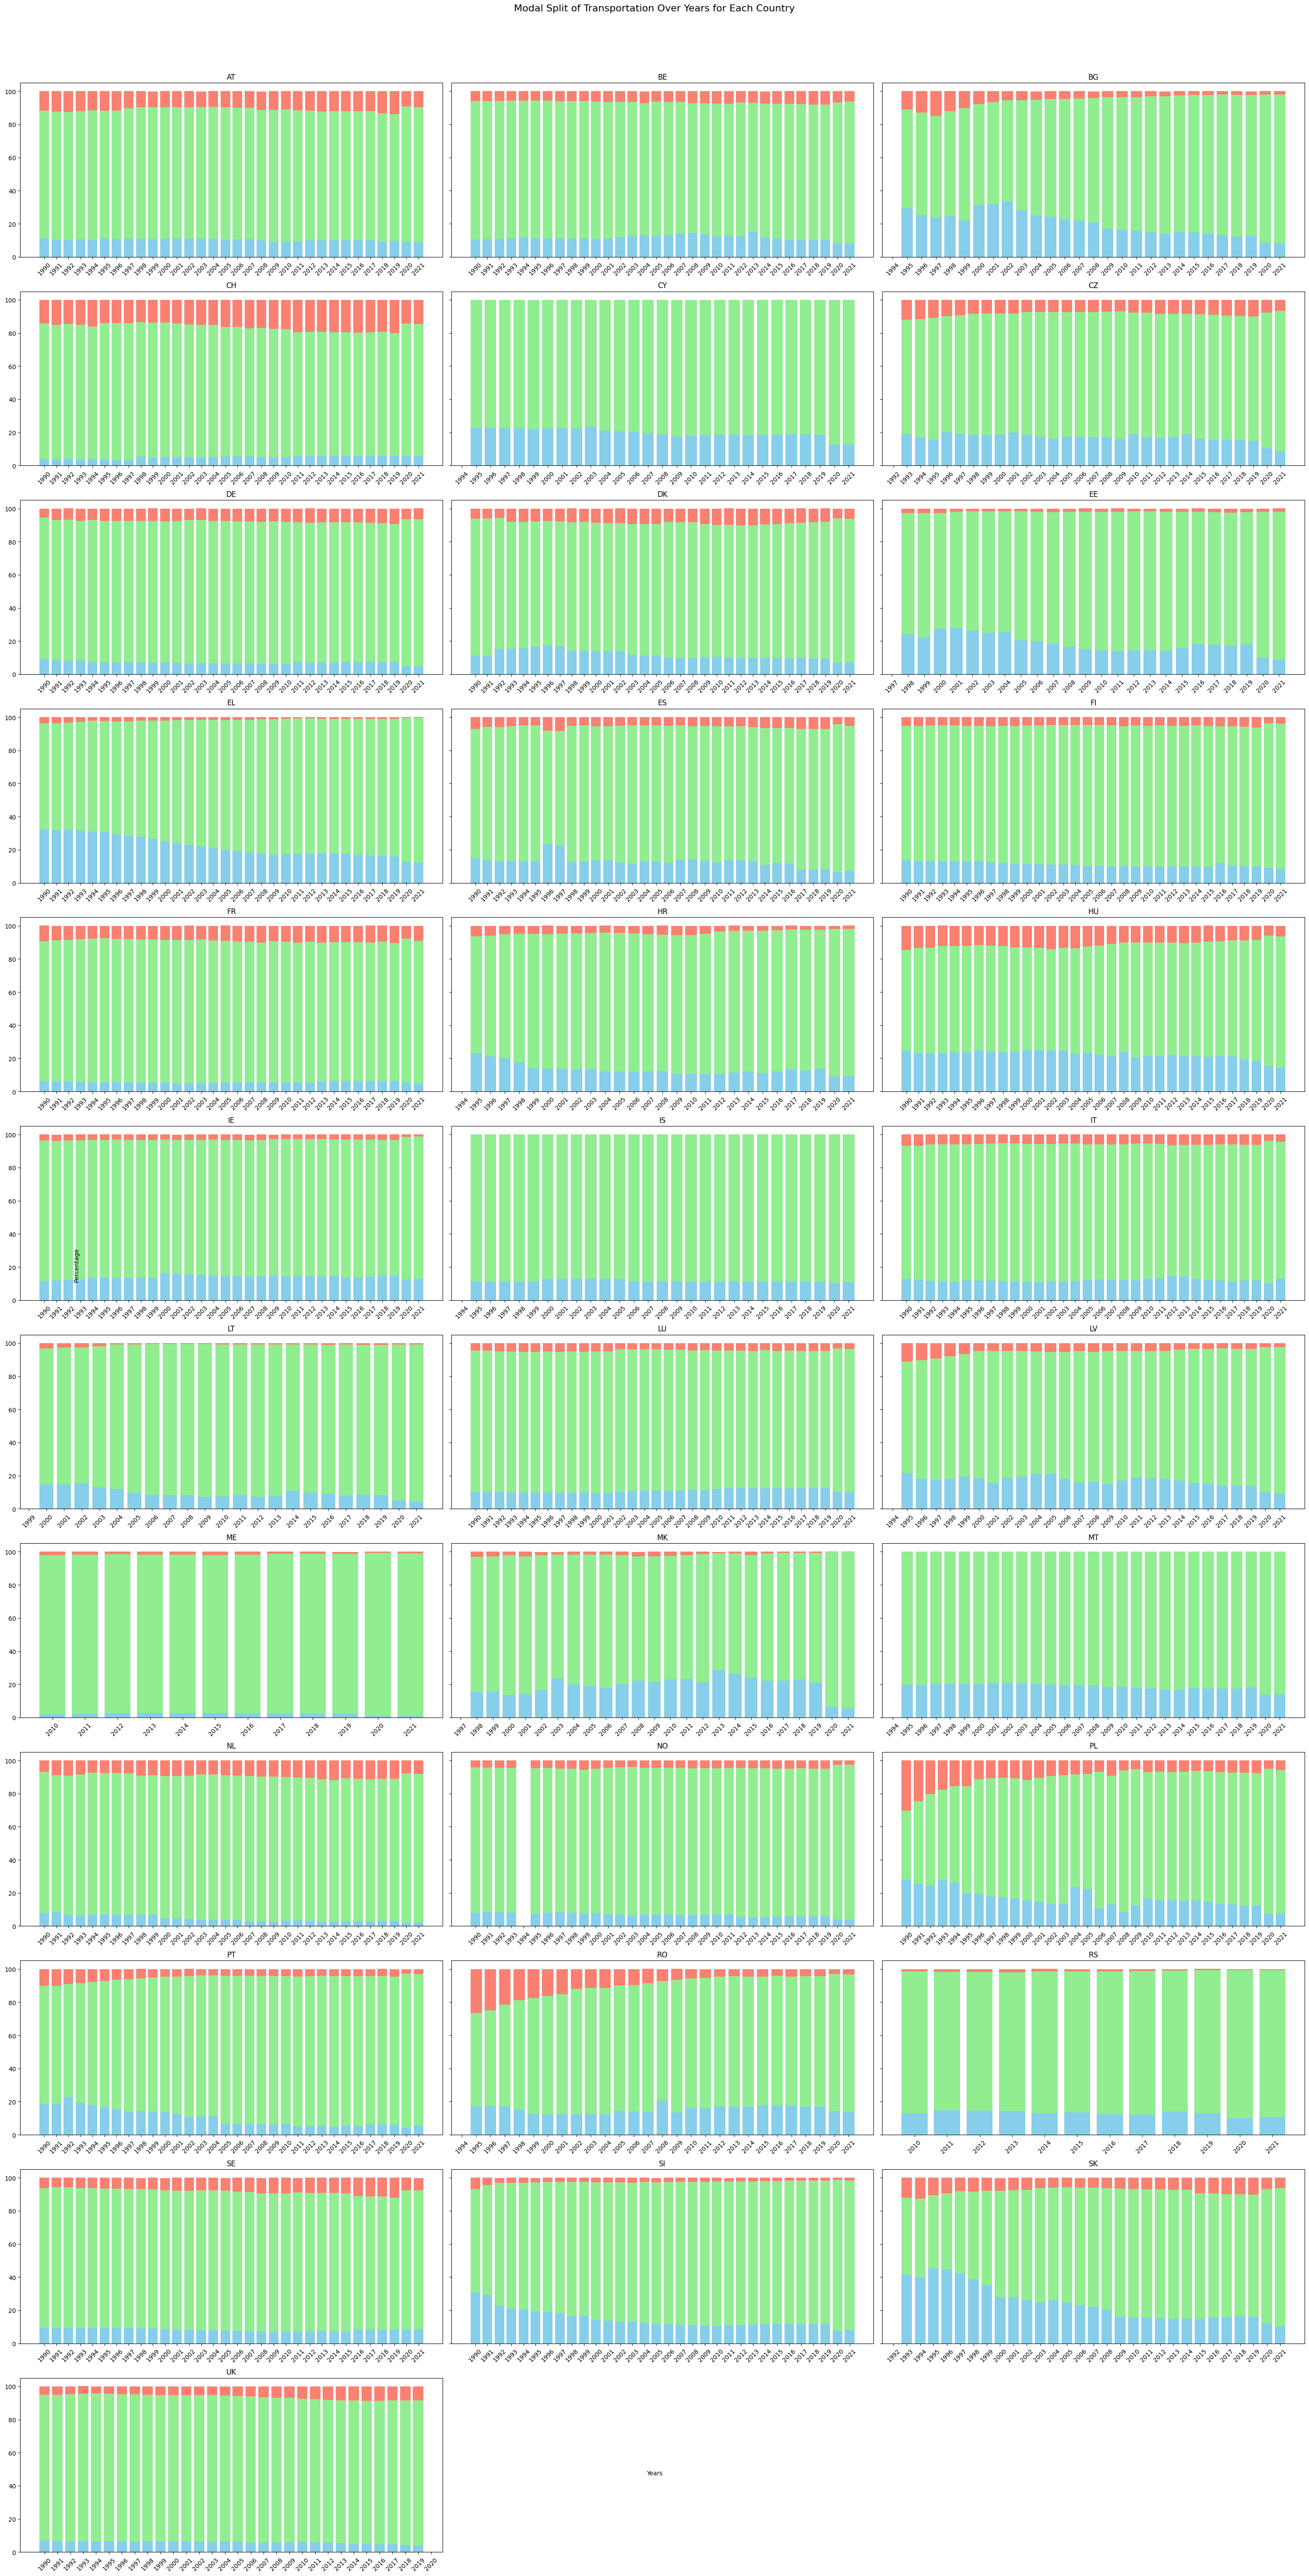

In [28]:
# Function to plot stacked bar plots for each country
def plot_stacked_bars_for_countries(bus_df, car_df, trn_df):
    # List of all countries
    countries = bus_df.index.unique()

    # Determine the grid size for subplots (fewer columns for more vertical spread)
    n_cols = 3  # Number of plots per row
    n_rows = -(-len(countries) // n_cols)  # Ceiling division for rows

    # Create figure and axes
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 5), sharey=True)

    # Flatten the axes array for easy iteration
    axs = axs.flatten()

    # Loop through each country and create a stacked bar plot
    for i, country in enumerate(countries):
        # Extract data for the selected country
        bus_data = bus_df.loc[country]
        car_data = car_df.loc[country]
        trn_data = trn_df.loc[country]

        # Ensure all dataframes have the same set of columns (years)
        common_years = bus_data.index.intersection(car_data.index).intersection(trn_data.index)
        bus_data = bus_data.reindex(common_years)
        car_data = car_data.reindex(common_years)
        trn_data = trn_data.reindex(common_years)

        # Plotting each transportation mode
        axs[i].bar(common_years, bus_data, label='Bus', color='skyblue')
        axs[i].bar(common_years, car_data, bottom=bus_data, label='Car', color='lightgreen')
        axs[i].bar(common_years, trn_data, bottom=bus_data+car_data, label='Train', color='salmon')

        axs[i].set_title(country)
        axs[i].tick_params(axis='x', rotation=45)

    # Set the overall figure title and labels
    fig.suptitle('Modal Split of Transportation Over Years for Each Country', fontsize=16)
    fig.text(0.5, 0.04, 'Years', ha='center', va='center')
    fig.text(0.06, 0.5, 'Percentage', ha='center', va='center', rotation='vertical')

    # Hide any unused subplots
    for j in range(i+1, len(axs)):
        axs[j].axis('off')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Plotting stacked bar plots for each country
plot_stacked_bars_for_countries(bus_df_cleaned, car_df_cleaned, trn_df_cleaned)

In our analysis below, we examined the overall trends of passenger volume in relation to GDP. It was intriguing to investigate whether travel was influenced by GDP. However, we encountered a challenge in interpreting the graph, as it was quite perplexing. After we plotted the relative passenger volume to GDP over the years, the plot's significance remained unclear. Did it signify an improvement in public transportation efficiency? Was the decrease attributed to an increase in GDP, a decrease in the volume of travelers, or a reduction in the distance they traveled? Due to the lack of comprehensive documentation for the data sourced from the Eurostat database, we decided to omit this plot from our analysis.

In [29]:
# Define the relative path to the CSV file
pkm_gdp_file_path = '../data/eurostat/volume of passenger transport relative to GDP(pkm divided by gdp) - tran_hv_pstra.csv'

# Read the CSV file
pkm_gdp_data = pd.read_csv(pkm_gdp_file_path)

# Convert to DataFrame
pkm_gdp_df = pd.DataFrame(pkm_gdp_data)

In [30]:
# Extracting country codes by splitting the 'unit,geo\\time' column and selecting the second part
pkm_gdp_df['country'] = pkm_gdp_df['unit,geo\\time'].str.split(',').str[1]

# Exclude specific geographical entities
excluded_geos = ['EU27_2020', 'EU28', 'TR']
pkm_gdp_df = pkm_gdp_df[~pkm_gdp_df['country'].isin(excluded_geos)]

# Drop 'unit,geo\\time' column
pkm_gdp_df.drop('unit,geo\\time', axis=1, inplace=True)

# Set 'country' as the index
pkm_gdp_df.set_index('country', inplace=True)

# Replace ":" with NaN and remove ' p', ' e', or ' ep' from entries
pkm_gdp_df.replace({":": np.nan, " p": "", " e": "", " ep": ""}, regex=True, inplace=True)

# Convert the data to float
for col in pkm_gdp_df.columns:
    pkm_gdp_df[col] = pd.to_numeric(pkm_gdp_df[col], errors='coerce')

# Display the first few rows of the DataFrame
pkm_gdp_df.head()

,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,...,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990
country,,,,,,,,,,,,,,,,,,,,,
AT,80.0,78.6,87.5,NaN,100.2,100.8,100,99.0,97.4,96.1,...,105.0,107.0,109.6,112.8,114.1,NaN,NaN,NaN,NaN,NaN
BE,NaN,NaN,93.8,95.5,96.6,97.4,100,NaN,111.5,NaN,...,122.7,124.6,124.4,126.9,128.9,NaN,NaN,NaN,NaN,NaN
BG,72.3,75.4,88.7,89.7,93.9,95.9,100,99.1,94.4,91.9,...,95.6,91.0,95.2,82.6,92.2,NaN,NaN,NaN,NaN,NaN
CH,86.7,86.0,97.5,97.1,99.6,99.8,100,100.7,101.9,102.9,...,120.5,120.8,120.4,122.0,120.8,123.0,128.3,131.0,133.9,128.4
CY,76.3,75.5,90.1,92.4,94.2,97.9,100,100.4,96.8,91.1,...,86.9,89.0,92.3,92.5,90.7,NaN,NaN,NaN,NaN,NaN


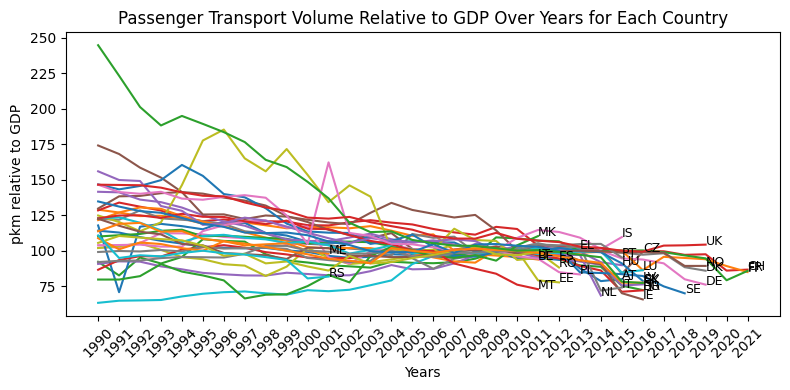

In [31]:
# Function to plot data with country code labels on each line
def plot_data_with_labels(df, title):
    plt.figure(figsize=(8, 4))

    # Convert the column names (years) to strings and sort them in ascending order for the x-axis
    year_columns = sorted(df.columns.astype(str))

    # Loop through each country and plot its data
    for country in df.index:
        # Ensure the data is in a float format for plotting and drop NaN values
        country_data = df.loc[country].reindex(year_columns).astype(float).dropna()
        if not country_data.empty:
            plt.plot(year_columns[:len(country_data)], country_data, label=country)
            # Add text label near the last point of each line
            last_year = year_columns[len(country_data) - 1]
            last_value = country_data.iloc[-1]
            plt.text(last_year, last_value, country, fontsize=9)

    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylabel('pkm relative to GDP')
    plt.xlabel('Years')
    plt.tight_layout()
    plt.show()

# Plotting Passenger Transport Volume Relative to GDP (pkm divided by GDP) with country labels
plot_data_with_labels(pkm_gdp_df, 'Passenger Transport Volume Relative to GDP Over Years for Each Country')

We took a look at the volume of rail passengers over the years. The unit "pkm" represented passenger kilometers, which is the product of the distance traveled and the number of passengers on the journey. This allowed us to observe that, over time, the volume of passengers increased.

Similarly, with the modal split data sourced from Eurostat, after importing and reading the data, we applied filters to exclude aggregated entries and excluded Turkey from our analysis to maintain our focus on European trends. To streamline our analysis, we removed flags indicating provisional or estimated data and treated missing values as NaN, ensuring a cleaner dataset.

In [32]:
# Define the relative path to the CSV file
rail_passengers_file_path = '../data/eurostat/number of rail passengers transported - rail_pa_total.csv'

# Read the CSV file
rail_passengers_data = pd.read_csv(rail_passengers_file_path)

# Convert to DataFrame
rail_passengers_df = pd.DataFrame(rail_passengers_data)

In [33]:
# Split 'unit,geo\\time' into 'unit' and 'country'
rail_passengers_df[['unit', 'country']] = rail_passengers_df['unit,geo\\time'].str.split(',', expand=True)
rail_passengers_df.drop('unit,geo\\time', axis=1, inplace=True)

# Replace ": c", ":", " :", ": ", ": p", and any trailing non-numeric characters (like " p") from data columns only
for col in rail_passengers_df.columns.drop(['unit', 'country']):
    rail_passengers_df[col] = rail_passengers_df[col].replace({": c": np.nan, ":": np.nan, " :": np.nan, ": ": np.nan, ": p": np.nan}, inplace=False)
    rail_passengers_df[col] = rail_passengers_df[col].replace(to_replace=r'[^\d.]+', value='', regex=True)

# Convert the column names (representing years) to strings
rail_passengers_df.columns = rail_passengers_df.columns.astype(str)

# Filter out EU27_2007 and EU27_2020
rail_passengers_df = rail_passengers_df[~rail_passengers_df['country'].isin(['EU27_2007', 'EU27_2020', 'EU28', 'TR'])]

# Create the dataframe
df_mio_pkm = rail_passengers_df[rail_passengers_df['unit'] == 'MIO_PKM'].drop('unit', axis=1).set_index('country')

# Display the DataFrame
print("Million Passenger Kilometers (MIO_PKM):")
display(df_mio_pkm.head())


Million Passenger Kilometers (MIO_PKM):


,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004
country,,,,,,,,,,,,,,,,,,,
AT,12855,8447,7375,13252,13122,12562,12497,12104,11981,11804,11211,10778,10263,10184,10365,9167,8907,8685,8274
BA,31,18,14,56,39,29,24,34,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10669,10498,10237,10139,9403,8964,8510,9225
BG,1600,1203,1118,1520,1476,1434,1455,1549,1698,1821,1870,2059,2090,2138,2317,2404,2411,NaN,NaN
CH,19201,14223,13261,21559,20451,20707,20657,20228,19934,19368,19180,19387,19093,18497,17699,NaN,NaN,NaN,NaN


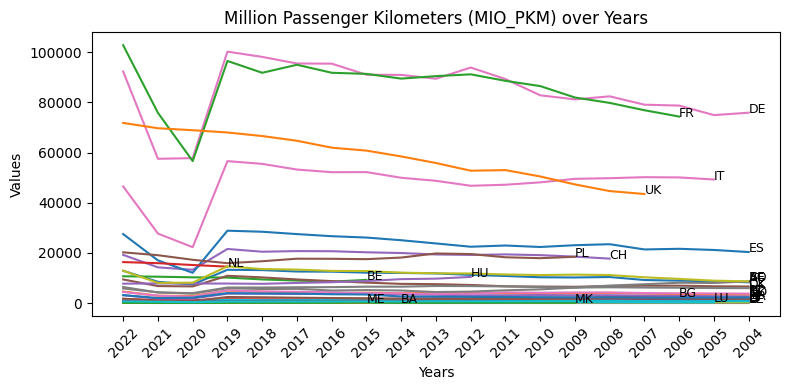

In [34]:
plt.figure(figsize=(8, 4))

# Convert the column names (years) to strings
year_columns = df_mio_pkm.columns.astype(str)

# Loop through each country and plot its data with country codes on the lines
for country in df_mio_pkm.index:
    # Ensure the data is in a float format for plotting and drop NaN values
    country_data = df_mio_pkm.loc[country].astype(float).dropna()
    if not country_data.empty:
        plt.plot(year_columns[:len(country_data)], country_data)
        # Add text label near the last point of each line
        last_year = year_columns[len(country_data) - 1]
        last_value = country_data.iloc[-1]
        plt.text(last_year, last_value, country, fontsize=9)

plt.title('Million Passenger Kilometers (MIO_PKM) over Years')
plt.xticks(rotation=45)
plt.ylabel('Values')
plt.xlabel('Years')
plt.tight_layout()
plt.show()


Another interesting factor is the immigration levels of the EU countries over the year to see if more immigrants mean more public transportation use. However a strong correlation was not observed. Immigration's impact on public transportation usage varies due to factors such as individual preferences, socioeconomic status, and access to transportation options. The relationship is complex and may not exhibit a strong and consistent correlation across all contexts.

In [35]:
# Define the relative path to the CSV file
immigration_file_path = '../data/eurostat/immigration.csv'

# Read the CSV file
immigration_data = pd.read_csv(immigration_file_path)

# Convert to DataFrame
immigration_df = pd.DataFrame(immigration_data)

In [36]:
# Filter rows containing 'COMPLET'
immigration_df = immigration_df[immigration_df['freq,citizen,agedef,age,unit,sex,geo\\TIME_PERIOD'].str.contains('COMPLET')]

# Split the first column and drop the original column
immigration_df[['freq', 'citizen', 'agedef', 'age', 'unit', 'sex', 'country']] = immigration_df['freq,citizen,agedef,age,unit,sex,geo\\TIME_PERIOD'].str.split(',', expand=True)
immigration_df.drop('freq,citizen,agedef,age,unit,sex,geo\\TIME_PERIOD', axis=1, inplace=True)

# Clean the data in the year columns
for col in immigration_df.columns.drop(['freq', 'citizen', 'agedef', 'age', 'unit', 'sex', 'country']):
    immigration_df[col] = immigration_df[col].replace({": c": np.nan, ":": np.nan, " :": np.nan, ": ": np.nan, ": p": np.nan}, inplace=False)
    immigration_df[col] = immigration_df[col].replace(to_replace=r'[^\d.]+', value='', regex=True)

# Convert the column names (years) to strings
immigration_df.columns = immigration_df.columns.astype(str)

# Drop unnecessary columns
immigration_df_cleaned = immigration_df.drop(['freq', 'citizen', 'agedef', 'age', 'unit', 'sex'], axis=1)

# Set 'country' as the index of the DataFrame
immigration_df_final = immigration_df_cleaned.set_index('country')

# Drop the row with 'EU27_2020' in the 'country' index
immigration_df_final = immigration_df_final.drop(['EU27_2020', 'TR', 'EA19', 'EA20'], errors='ignore')

# Display the final DataFrame
immigration_df_final.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
country,,,,,,,,,,,,
AT,70978,82230,91557,101866,116262,166323,129509,111801,105633,109167,103565,118511
BE,135281,147377,129477,120078,123158,146626,123702,126703,137860,150006,118683,139743
BG,NaN,NaN,14103,18570,26615,25223,21241,25597,29559,37929,37364,39461
CH,161778,148799,149051,160157,156282,153627,149305,143377,144857,145129,138778,144907
CY,20206,23037,17476,13149,9212,15183,17391,21306,23442,26170,25861,24001


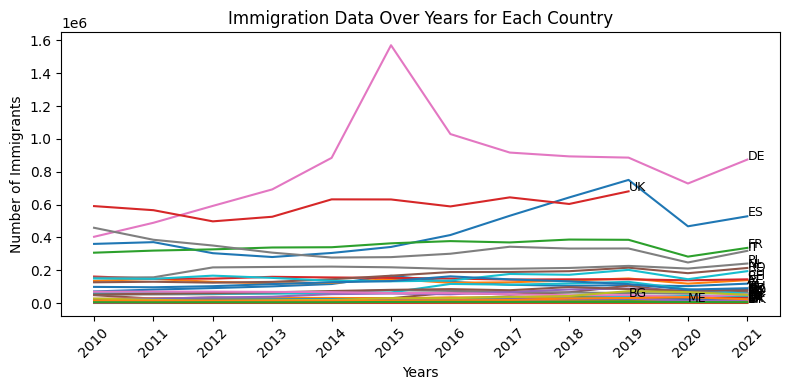

In [37]:
# Function to plot data with country code labels on each line
def plot_data_with_labels(df, title):
    plt.figure(figsize=(8, 4))

    # Convert the column names (years) to strings
    year_columns = df.columns.astype(str)

    # Loop through each country and plot its data
    for country in df.index:
        # Ensure the data is in a float format for plotting and drop NaN values
        country_data = df.loc[country].astype(float).dropna()
        if not country_data.empty:
            plt.plot(year_columns[:len(country_data)], country_data, label=country)
            # Add text label near the last point of each line
            last_year = year_columns[len(country_data) - 1]
            last_value = country_data.iloc[-1]
            plt.text(last_year, last_value, country, fontsize=9)

    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylabel('Number of Immigrants')
    plt.xlabel('Years')
    plt.tight_layout()
    plt.show()

# Plotting Immigration Data with country labels
plot_data_with_labels(immigration_df_final, 'Immigration Data Over Years for Each Country')


In [38]:
# Define the relative path to the CSV file
hicp_file_path = '../data/eurostat/average-annual-HICP.csv'

# Read the CSV file
hicp_data = pd.read_csv(hicp_file_path)

# Convert to DataFrame
hicp_df = pd.DataFrame(hicp_data)

Finally, the Eurostat database contains information about the HICP for the European countries. The Harmonised Index of Consumer Prices (HICP) is a measure of inflation and price stability for the European Union (EU). It's designed to provide a consistent and comparable measure of consumer price inflation across EU member states. We want to see if inflation has an impact on the type of transportation that europeans use.

However, when we examined its relationship with transportation choices through a heatmap, an unexpected finding emerged: inflation appeared to have a positive correlation with car usage, contrary to the anticipated trend. Due to this counterintuitive result, we opted to exclude this plot from our analysis.

In [39]:
# Split the first column and drop the original column
hicp_df[['freq', 'unit', 'coicop', 'country']] = hicp_df['freq,unit,coicop,geo\\TIME_PERIOD'].str.split(',', expand=True)
hicp_df.drop('freq,unit,coicop,geo\\TIME_PERIOD', axis=1, inplace=True)

# Before dropping rows, ensure 'country' column is of type string to avoid unexpected behavior
hicp_df['country'] = hicp_df['country'].astype(str)

# Drop the rows where 'country' column matches 'TR', 'EU27_2020', 'EA19', or 'EA20'
countries_to_drop = ['TR', 'EU27_2020', 'EA19', 'EA20']
hicp_df = hicp_df[~hicp_df['country'].isin(countries_to_drop)]

# Clean the data in the year columns
for col in hicp_df.columns.drop(['freq', 'unit', 'coicop', 'country']):
    hicp_df[col] = hicp_df[col].replace({":": np.nan, ": d": np.nan, " d": ""}, inplace=False, regex=True)
    hicp_df[col] = hicp_df[col].astype(float)

# Set 'country' as the index of the DataFrame
hicp_df_final = hicp_df.drop(['freq', 'unit', 'coicop'], axis=1).set_index('country')

# Display the cleaned DataFrame
hicp_df_final.head()

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
country,,,,,,,,,,,,
AL,NaN,NaN,NaN,NaN,101.51,104.76,106.59,108.39,110.74,113.26,120.69,127.13
AT,95.75,97.77,99.20,100.0,100.97,103.22,105.41,106.98,108.47,111.46,121.07,130.40
BE,97.68,98.90,99.38,100.0,101.77,104.03,106.44,107.77,108.23,111.71,123.26,126.07
BG,102.33,102.72,101.08,100.0,98.68,99.85,102.48,104.99,106.27,109.30,123.52,134.15
CH,100.76,100.83,100.84,100.0,99.47,100.11,101.03,101.41,100.56,101.04,103.74,106.10


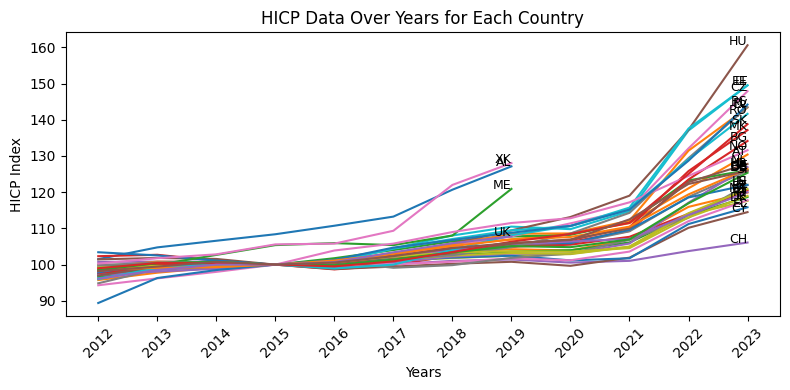

In [40]:
# Function to plot data with country code labels on each line
def plot_data_with_labels(df, title):
    plt.figure(figsize=(8, 4))

    # Convert the column names (years) to strings
    year_columns = df.columns.astype(str)

    # Loop through each country and plot its data
    for country in df.index:
        # Ensure the data is in a float format for plotting and drop NaN values
        country_data = df.loc[country].dropna()
        if not country_data.empty:
            plt.plot(year_columns[:len(country_data)], country_data, label=country)
            # Add text label near the last point of each line
            last_year = year_columns[len(country_data) - 1]
            last_value = country_data.iloc[-1]
            plt.text(last_year, last_value, country, fontsize=9, ha='right')

    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylabel('HICP Index')
    plt.xlabel('Years')
    plt.tight_layout()
    plt.show()

# Plotting HICP Data with country labels
plot_data_with_labels(hicp_df_final, 'HICP Data Over Years for Each Country')
